In [1]:
from deepsparse.pipeline import Pipeline
from transformers import AutoTokenizer
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load SST-2 validation split
dataset = load_dataset("glue", "sst2", split="validation")

# Initialize DeepSparse pipeline for pruned SST-2 model
stub = "zoo:distilbert-sst2_wikipedia_bookcorpus-pruned80.4block_quantized"
pipeline = Pipeline.create(task="text_classification", model_path=stub, batch_size=1)

print("✅ Loaded pruned SST-2 model pipeline")



2025-06-01 21:41:27 deepsparse.pipeline WARNING  Could not create v2 'sentiment_analysis' pipeline, trying legacy
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.8.0 COMMUNITY | (e3778e93) (release) (optimized) (system=avx2, binary=avx2)
[779c04647000 >WARN<  operator() ./src/include/wand/utility/warnings.hpp:14] Generating emulated code for quantized (INT8) operations since no VNNI instructions were detected. Set NM_FAST_VNNI_EMULATION=1 to increase performance at the expense of accuracy.


✅ Loaded pruned SST-2 model pipeline


Evaluating routing thresholds:  10%|█         | 1/10 [00:10<01:32, 10.27s/it]

Threshold 0.00 - Accuracy: 0.9048 on 872 samples


Evaluating routing thresholds:  20%|██        | 2/10 [00:14<00:52,  6.53s/it]

Threshold 0.11 - Accuracy: 0.9048 on 872 samples


Evaluating routing thresholds:  30%|███       | 3/10 [00:18<00:38,  5.51s/it]

Threshold 0.22 - Accuracy: 0.9048 on 872 samples


Evaluating routing thresholds:  40%|████      | 4/10 [00:22<00:29,  4.91s/it]

Threshold 0.33 - Accuracy: 0.9048 on 872 samples


Evaluating routing thresholds:  50%|█████     | 5/10 [00:35<00:39,  7.83s/it]

Threshold 0.44 - Accuracy: 0.9048 on 872 samples


Evaluating routing thresholds:  60%|██████    | 6/10 [00:44<00:32,  8.14s/it]

Threshold 0.56 - Accuracy: 0.9066 on 867 samples


Evaluating routing thresholds:  70%|███████   | 7/10 [00:48<00:20,  6.85s/it]

Threshold 0.67 - Accuracy: 0.9103 on 858 samples


Evaluating routing thresholds:  80%|████████  | 8/10 [00:52<00:11,  5.95s/it]

Threshold 0.78 - Accuracy: 0.9129 on 850 samples


Evaluating routing thresholds:  90%|█████████ | 9/10 [00:56<00:05,  5.37s/it]

Threshold 0.89 - Accuracy: 0.9195 on 832 samples


Evaluating routing thresholds: 100%|██████████| 10/10 [01:00<00:00,  6.07s/it]

Threshold 1.00 - Accuracy: 0.0000 on 0 samples


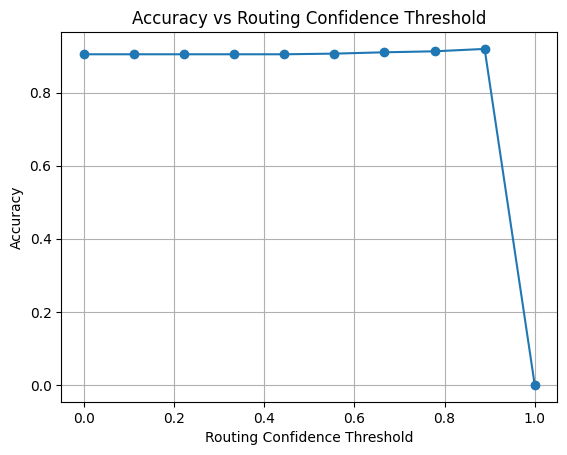

In [17]:
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

accuracies = []

for threshold in tqdm(routing_percentages, desc="Evaluating routing thresholds"):
    correct = 0
    total = 0

    for sample in dataset:
        text = sample['sentence']
        label = sample['label']

        output = pipeline(text)  # Not a list, it's a TextClassificationOutput object
        score = output.scores[0]  # Get confidence score
        label_str = output.labels[0]  # Get predicted label as string
        pred_label = 1 if label_str.upper() == 'POSITIVE' else 0

        if score > threshold:
            correct += int(pred_label == label)
            total += 1

    acc = correct / total if total > 0 else 0
    accuracies.append(acc)
    print(f"Threshold {threshold:.2f} - Accuracy: {acc:.4f} on {total} samples")

# Plot results
plt.plot(routing_percentages, accuracies, marker='o')
plt.xlabel("Routing Confidence Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Routing Confidence Threshold")
plt.grid(True)
plt.show()

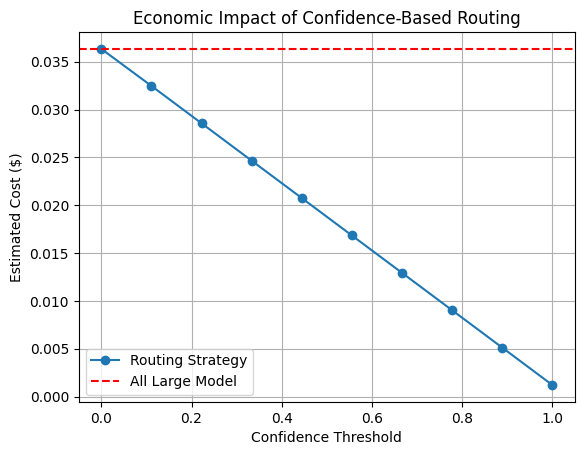

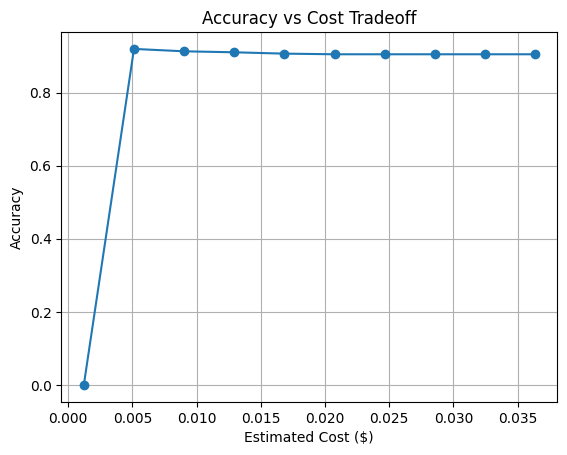

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumptions ---
cheap_model_throughput = 100  # samples/sec for pruned model (e.g., DeepSparse on CPU)
large_model_throughput = 10   # samples/sec for large fallback model (e.g., full BERT on GPU)

cpu_cost_per_hour = 0.5       # USD per hour for CPU
gpu_cost_per_hour = 1.5       # USD per hour for GPU

num_samples = len(dataset)

# Use routing_percentages from earlier
handled_by_cheap = [int(thresh * num_samples) for thresh in routing_percentages]
handled_by_large = [num_samples - x for x in handled_by_cheap]

# --- Cost computation function ---
def compute_cost(cheap, large):
    time_cheap = cheap / cheap_model_throughput
    time_large = large / large_model_throughput
    return (time_cheap / 3600) * cpu_cost_per_hour + (time_large / 3600) * gpu_cost_per_hour

all_large_cost = compute_cost(0, num_samples)
routing_costs = [compute_cost(c, l) for c, l in zip(handled_by_cheap, handled_by_large)]

# --- Plot Cost vs Threshold ---
plt.plot(routing_percentages, routing_costs, marker='o', label="Routing Strategy")
plt.axhline(all_large_cost, color='r', linestyle='--', label="All Large Model")
plt.xlabel("Confidence Threshold")
plt.ylabel("Estimated Cost ($)")
plt.title("Economic Impact of Confidence-Based Routing")
plt.legend()
plt.grid(True)
plt.show()

# --- (Optional) Plot Accuracy vs Cost ---
plt.plot(routing_costs, accuracies, marker='o')
plt.xlabel("Estimated Cost ($)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Cost Tradeoff")
plt.grid(True)
plt.show()
